In [13]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
from numpy.linalg import eigvals

def compute_lambda_max_vs_q(mu=0.95, sigma=0.05, zeta=None, d=4, p_memory=1, 
                             m_values=[1, 2, 3], q_range=np.linspace(0.80, 1.0, 50)):
    """
    Computes lambda_max for a range of q values given fidelity and network parameters.

    Parameters:
    - mu: Mean of the truncated Gaussian fidelity distribution
    - sigma: Standard deviation of the fidelity distribution
    - zeta: Dictionary of fidelity thresholds per hyperedge degree
    - d: Node degree at level 2
    - p_memory: Node memory survival probability
    - m_values: List of hyperedge degrees to consider
    - q_range: Range of q values (success probabilities) to simulate

    Returns:
    - q_range: The input range of q values
    - lambda_max_list: Corresponding list of lambda_max values
    """
    if zeta is None:
        zeta = {1: 0.85, 2: 0.90, 3: 0.95}

    # Fidelity distribution setup
    lower, upper = 0.5, 1.0
    a, b = (lower - mu) / sigma, (upper - mu) / sigma
    fidelity_dist = truncnorm(a, b, loc=mu, scale=sigma)
    p_fid_dict = {m: 1 - fidelity_dist.cdf(zeta[m]) for m in m_values}

    lambda_max_list = []

    for q in q_range:
        # Define p_H for each level
        p_H_dict = {
            m: (q * p_fid_dict[m]) if m == 1 else (q**(m + 1) * (p_fid_dict[m]**m))
            for m in m_values
        }

        # Degree distributions
        max_k = d
        P_qm = {}
        for m in m_values:
            if m == 1:
                p_1GHZ = q * p_fid_dict[m]
            else:
                p_1GHZ = q**m * (p_fid_dict[m]**m) * math.comb((d - 1), (m - 1))
            probs = [math.comb(d, k) * (p_1GHZ)**k * (1 - p_1GHZ)**(d - k) for k in range(max_k + 1)]
            probs = np.array(probs)
            probs /= probs.sum()
            P_qm[m] = probs

        # Expectations
        E_q = {m: sum(k * P_qm[m][k] for k in range(max_k + 1)) for m in m_values}
        E_q_q = {(m, mp): sum(k * kp * P_qm[m][k] * P_qm[mp][kp]
                              for k in range(max_k + 1) for kp in range(max_k + 1))
                 for m in m_values for mp in m_values}

        # Jacobian matrix
        G = np.zeros((len(m_values), len(m_values)))
        for i, m in enumerate(m_values):
            for j, mp in enumerate(m_values):
                numerator = E_q_q[(m, mp)] - (1 if m == mp else 0) * E_q[m]
                G[i, j] = p_H_dict[mp] * p_memory**(mp - 1) * (mp - 1) * numerator / E_q[m]

        lambda_max = max(eigvals(G)).real
        lambda_max_list.append(lambda_max)

    return q_range, lambda_max_list

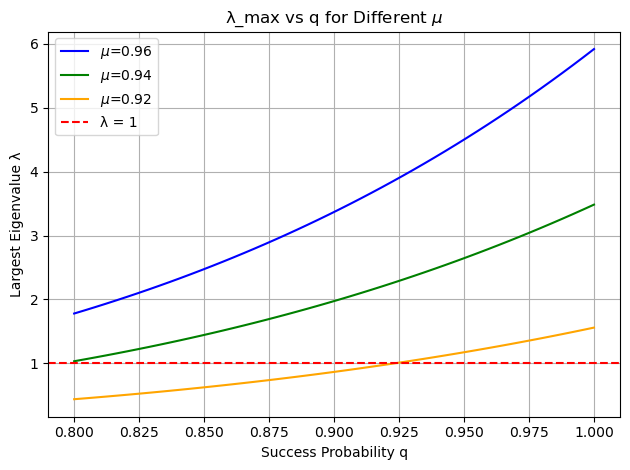

In [14]:
mus = [0.96, 0.94, 0.92]
colors = ['blue', 'green', 'orange']

for mu, color in zip(mus, colors):
    q_vals, lambda_vals = compute_lambda_max_vs_q(mu=mu)
    plt.plot(q_vals, lambda_vals, label=f'$\mu$={mu}', color=color)

plt.axhline(y=1, color='r', linestyle='--', label='λ = 1')
plt.xlabel('Success Probability q')
plt.ylabel('Largest Eigenvalue λ')
plt.title('λ_max vs q for Different $\mu$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

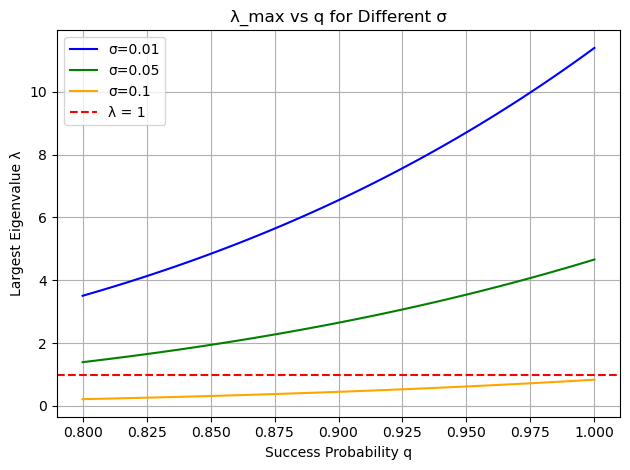

In [18]:
import matplotlib.pyplot as plt

sigmas = [0.01, 0.05, 0.1]
colors = ['blue', 'green', 'orange']

for sigma, color in zip(sigmas, colors):
    q_vals, lambda_vals = compute_lambda_max_vs_q(sigma=sigma)
    plt.plot(q_vals, lambda_vals, label=f'σ={sigma}', color=color)

plt.axhline(y=1, color='r', linestyle='--', label='λ = 1')
plt.xlabel('Success Probability q')
plt.ylabel('Largest Eigenvalue λ')
plt.title('λ_max vs q for Different σ')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()